<a href="https://colab.research.google.com/github/petersun1937/sarcasm_detection/blob/main/Sarcasm_Detection_with_BiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy pandas tensorflow keras matplotlib seaborn nltk swifter gensim


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 49.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 16.9 MB/s eta 0:00:00
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16507 sha256=63205571ac8246dd58f899bfc6994a0de45e49bf8fdf8a95d0b6ddcaf067d8cb
  Stored in directory: /root/.cache/pip/wheels/ef/7f/bd/9bed48f078f3ee1fa75e0b29b6e0335ce1cb03a38d3443b3a3
Successfully built swifter


In [66]:
import pandas as pd

# Load train dataset
train_path = "train.csv"  # Update path if needed
test_path = "test.csv"    # Update path if needed

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

# Display first few rows
print("Train Dataset Sample:")
print(df_train.head())

print("\nTest Dataset Sample:")
print(df_test.head())

# Check data distribution
print("\nClass Distribution in Train Set:")
print(df_train['class'].value_counts())

print("\nClass Distribution in Test Set:")
print(df_test['class'].value_counts())

Train Dataset Sample:
                                              tweets       class
0  Be aware  dirty step to get money  #staylight ...  figurative
1  #sarcasm for #people who don't understand #diy...  figurative
2  @IminworkJeremy @medsingle #DailyMail readers ...  figurative
3  @wilw Why do I get the feeling you like games?...  figurative
4  -@TeacherArthurG @rweingarten You probably jus...  figurative

Test Dataset Sample:
                                              tweets       class
0  no one ever predicted this was going to happen...  figurative
1  @Stooshie its as closely related as Andrews or...  figurative
2  I find it ironic when Vegans say they love foo...  figurative
3  Quick rt that throwing money vine I've not see...  figurative
4  yep, keep adding me to your #devops lists.... ...  figurative

Class Distribution in Train Set:
class
figurative    21238
irony         20894
sarcasm       20681
regular       18595
Name: count, dtype: int64

Class Distribution in Test Se

In [80]:
import re
import pandas as pd
import swifter

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"https?://\S+|www\.\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)  # Remove mentions
    text = re.sub(r"#(irony|sarcasm|sarcastic|ironic)\b", "", text)  # Remove #irony/ironic and #sarcasm/sarcastic
    #text = re.sub(r"[^a-zA-Z0-9'!?]", " ", text)  # Keep only relevant characters
    text = re.sub(r"[^a-zA-Z0-9#'!?]", " ", text)  # Keep only relevant characters
    return " ".join(text.split())  # Remove extra spaces


# Apply cleaning with Swifter (parallelized)
df_train['cleaned_tweet'] = df_train['tweets'].swifter.apply(clean_text)
df_test['cleaned_tweet'] = df_test['tweets'].swifter.apply(clean_text)

# Debug print: Check if URLs are gone
print(df_train["cleaned_tweet"].sample(10))


Pandas Apply:   0%|          | 0/81408 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8119 [00:00<?, ?it/s]

35378    some people in carp fishing disgust me rather ...
67588                        no i would never have guessed
45079    charles koch obama attack was a 'farewell gest...
54595    it's clear the new pat rule has teeth #espn #news
22795    tweet this as the poolside terrace is on fire!...
35088    stop throwing shade at people goddamn it's not...
14518    they don't have enough money for a roof! pleas...
75876    good god yes deray black ppl genetically carry...
27564    you'll do 98 right n a girl will still leave u...
33985    is it ironic that #blacklivesmatter is funded ...
Name: cleaned_tweet, dtype: object


In [81]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Drop rows with NaN in the 'class' column
df_train = df_train.dropna(subset=['class'])
df_test = df_test.dropna(subset=['class'])

# Tokenize
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(df_train['cleaned_tweet'])

train_sequences = tokenizer.texts_to_sequences(df_train['cleaned_tweet'])
test_sequences = tokenizer.texts_to_sequences(df_test['cleaned_tweet'])

# Pad sequences
max_length = max(len(seq) for seq in train_sequences)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding="post")
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding="post")

## Ensure train and test datasets have the same classes
common_classes = set(df_train['class']).intersection(set(df_test['class']))
df_test = df_test[df_test['class'].isin(common_classes)]

# Label Encoding (Single call)
label_encoder = LabelEncoder()
df_train['encoded_class'] = label_encoder.fit_transform(df_train['class'])
df_test['encoded_class'] = label_encoder.transform(df_test['class'])

# Convert labels to Numpy arrays
train_labels = np.array(df_train['encoded_class'])
test_labels = np.array(df_test['encoded_class'])

# Ensure no mismatch
assert train_padded.shape[0] == train_labels.shape[0], "train_padded and train_labels mismatch"


In [87]:
# Split train into train and val
train_padded, val_padded, train_labels, val_labels = train_test_split(
    train_padded, train_labels, test_size=0.2, stratify=train_labels, shuffle=True
)

# Shuffle
train_padded, train_labels = shuffle(train_padded, train_labels)

print("\nClass Distribution in Training Set:\n", pd.Series(train_labels).value_counts(normalize=True))
print("\nClass Distribution in Validation Set:\n", pd.Series(val_labels).value_counts(normalize=True))
print("\nClass Distribution in Test Set:\n", pd.Series(test_labels).value_counts(normalize=True))


Class Distribution in Training Set:
 0    0.260883
1    0.256660
3    0.254050
2    0.228407
Name: proportion, dtype: float64

Class Distribution in Validation Set:
 0    0.260863
1    0.256641
3    0.254030
2    0.228466
Name: proportion, dtype: float64

Class Distribution in Test Set:
 1    0.260007
3    0.259268
0    0.251755
2    0.228969
Name: proportion, dtype: float64


In [88]:
import gensim.downloader as api
import numpy as np

# Load GloVe 50D from gensim
glove_model = api.load("glove-wiki-gigaword-50")
embedding_dim = 50  # GloVe 50D

# Initialize embedding matrix
embedding_matrix = np.zeros((5000, embedding_dim))

# Fill embedding matrix with GloVe vectors
for word, index in tokenizer.word_index.items():
    if index < 5000:
        if word in glove_model:
            embedding_matrix[index] = glove_model[word]

In [ ]:
import gensim.downloader as api
import numpy as np

# Load Pretrained Word2Vec (Google News 300D)
word2vec_model = api.load("word2vec-google-news-300")
embedding_dim = 300  # Word2Vec uses 300 dimensions

# Initialize embedding matrix
embedding_matrix = np.zeros((5000, embedding_dim))

# Fill embedding matrix with Word2Vec vectors
for word, index in tokenizer.word_index.items():
    if index < 5000:
        if word in word2vec_model:
            embedding_matrix[index] = word2vec_model[word]


In [89]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, Bidirectional, BatchNormalization, LayerNormalization, RNN, LSTMCell
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Define model

# Use pretrained embeddings
# Bidirectional single LSTM layer
model = Sequential([
    Embedding(input_dim=5000, output_dim=50, weights=[embedding_matrix], input_length=max_length, trainable=True),

    Bidirectional(LSTM(128, return_sequences=False, dropout=0.5)),  # Single LSTM layer, outputting final sequence
    BatchNormalization(),  # Helps stabilize training

    Dense(32, activation='relu'),
    Dropout(0.5),

    Dense(4, activation='softmax')  # Output layer
])

# Bidirectional 2 LSTM layers
'''model = Sequential([
    Embedding(input_dim=5000, output_dim=50, weights=[embedding_matrix], input_length=max_length, trainable=True),
    #Embedding(input_dim=5000, output_dim=300, weights=[embedding_matrix], input_length=max_length, trainable=True),  # Word embeddings
    Bidirectional(LSTM(256, return_sequences=True, dropout=0.5)),
    BatchNormalization(),  # Stabilizes training
    Bidirectional(LSTM(128, return_sequences=False, dropout=0.5)),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])'''


# CNN with LSTM
'''model = Sequential([
    Embedding(input_dim=5000, output_dim=50, weights=[embedding_matrix], input_length=max_length, trainable=True),
    Conv1D(filters=64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    LSTM(64),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 output classes
])'''

# Self trained emb with 2 LSTMs
'''model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=max_length),  # Word embeddings
    LSTM(128, return_sequences=True),  # First LSTM layer with return_sequences=True
    BatchNormalization(),  # Stabilizes training
    LSTM(64),  # Second LSTM layer
    Dense(64, activation='relu'),  # Fully connected layer
    Dropout(0.5),  # Dropout for regularization
    Dense(4, activation='softmax')  # Output layer with softmax activation for 4 classes
])'''

# Self trained emb with 2 BiLSTMs
'''model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=max_length),  # Word embeddings

    Bidirectional(LSTM(256, return_sequences=True, dropout=0.5)),

    BatchNormalization(),  # Stabilizes training

    Bidirectional(LSTM(128, return_sequences=False, dropout=0.5)),

    Dense(32, activation='relu'),  # Fully connected
    Dropout(0.5),  # Dropout for regularization

    Dense(4, activation='softmax')  # Output layer with softmax (4 classes)
])'''


# define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

optimizer = Adam(learning_rate=0.001, clipvalue=1.0)  # default 0.001

# Compile Model
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display summary
model.build((None, max_length))
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_24 (Embedding)             │ (None, 34, 50)              │         250,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_17 (Bidirectional)     │ (None, 256)                 │         183,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 32)                  │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 442,676 (1.69 MB)

 Trainable params: 442,164 (1.69 MB)

 Non-trainable params: 512 (2.00 KB)

In [90]:
# Train model
history = model.fit(train_padded, train_labels, epochs=15, batch_size=32, validation_data=(val_padded, val_labels), callbacks=[early_stopping], shuffle=True)

Epoch 1/15
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.3843 - loss: 1.2811 - val_accuracy: 0.5296 - val_loss: 0.9105
Epoch 2/15
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.5228 - loss: 0.9250 - val_accuracy: 0.5568 - val_loss: 0.8700
Epoch 3/15
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.5516 - loss: 0.8877 - val_accuracy: 0.5676 - val_loss: 0.8464
Epoch 4/15
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.5772 - loss: 0.8557 - val_accuracy: 0.5816 - val_loss: 0.8282
Epoch 5/15
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.5963 - loss: 0.8238 - val_accuracy: 0.5882 - val_loss: 0.8225
Epoch 6/15
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.6071 - loss: 0.8158 - val_accuracy: 0.5883 - val_loss: 0.8207
Epoch 7/15
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.6070 - loss: 0.8057 - val_accuracy: 0.5925 - val_loss: 0.8211
Epoch 8/15
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.6127 - loss: 0

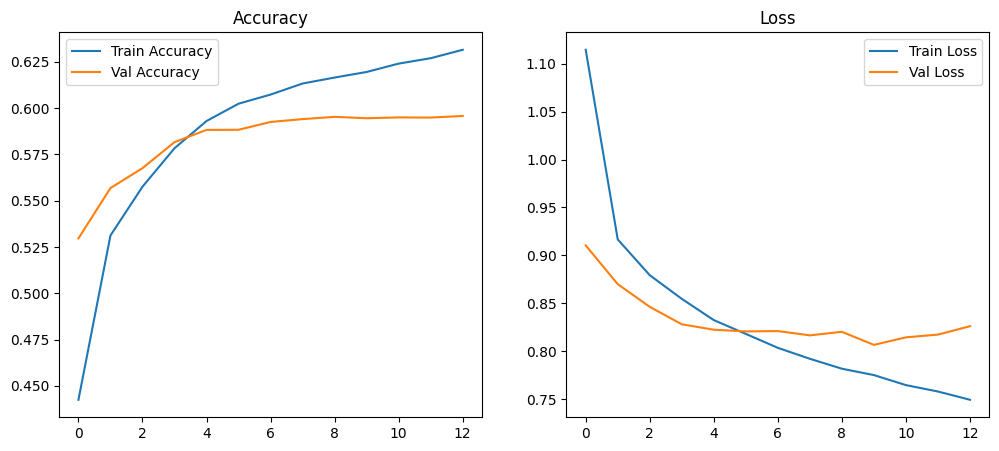

In [91]:
import matplotlib.pyplot as plt

# Plot accuracy and loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()


In [92]:
def predict_sarcasm(text):
    clean = clean_text(text)
    seq = tokenizer.texts_to_sequences([clean])
    pad = pad_sequences(seq, maxlen=max_length, padding="post")
    prediction = model.predict(pad)
    predicted_class = label_encoder.inverse_transform([np.argmax(prediction)])[0]
    return predicted_class

import random

# Randomly select 10 samples from the test set
num_samples = 10
random_indices = random.sample(range(len(df_test)), num_samples)
test_samples = df_test.iloc[random_indices]

# Run predictions
for index, row in test_samples.iterrows():
    text = row['cleaned_tweet']  # Use the original tweet text
    true_label = row['class']  # Actual label
    prediction = predict_sarcasm(text)  # Your prediction function

    print(f"Tweet: {text}")
    print(f"True Label: {true_label}")
    print(f"Predicted: {prediction}")
    print("-" * 50)






1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
Tweet: funny scene dr bailey #greysanatomy #tgit
True Label: figurative
Predicted: irony
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Tweet: evoria on 2nd pre event sipa 2015 last night at the park mall solo baru #latepost #late #lateposts
True Label: regular
Predicted: regular
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Tweet: chad and avril split! did not see that coming
True Label: sarcasm
Predicted: irony
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Tweet: lot of legal scholars active on twitter today #nfl #deflategate #judgeberman
True Label: sarcasm
Predicted: irony
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Tweet: my god they're such an eyesore someone tell the commissioner! #prettysustainableenergy
True Label: figurative
Predicted: sarcasm
------------------------

In [93]:
print(df_train['class'].value_counts(normalize=True))

class
figurative    0.260883
irony         0.256658
sarcasm       0.254041
regular       0.228417
Name: proportion, dtype: float64


In [94]:
# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(test_padded, test_labels)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3250 - loss: 0.9680

Test Accuracy: 0.5951
Test Loss: 0.8194
